**Libraries import**

In [ ]:
import random
import numpy as np
import pandas as pd

import sklearn
from sklearn import datasets
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV

from tensorflow import keras
from keras.callbacks import LambdaCallback
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras import optimizers
from IPython.display import clear_output

import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 7.0)

# MLP (sklearn) California_house_df

**Dataset review**

In [ ]:
seed = 1
np.random.seed(seed)

**Dataset downloading:**

In [ ]:
house_val = datasets.fetch_california_housing()

**Reflecting the keys:**

In [ ]:
house_val.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'feature_names', 'DESCR'])

**General overview for chosen dataset (DataFrame form):**

In [ ]:
house_val_df = pd.DataFrame(data=house_val['data'], columns=house_val['feature_names'])

house_val_df[house_val['target_names'][0],'target'] = house_val['target']

In [ ]:
# house_val_df.isna().sum()

house_val_df.head(5)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,"(MedHouseVal, target)"
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


**Description of the dataset:**

In [ ]:
print(house_val['DESCR'])

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

**Reflecting shape of the input data:**

In [ ]:
house_val['data'].shape

(20640, 8)

**Median house value ('target') distribution:**

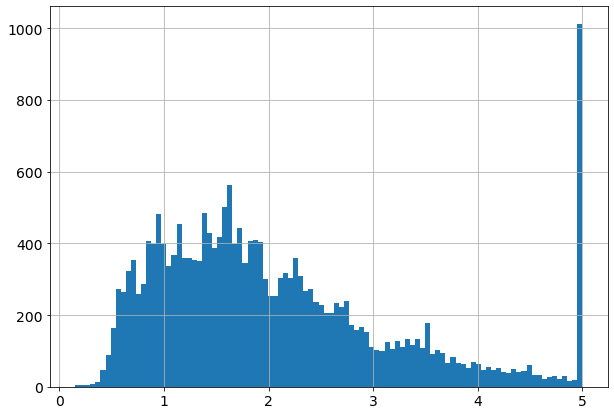

In [ ]:
pd.Series(house_val['target']).hist(bins=100);

**Data preparation**

In [ ]:
x_df = pd.DataFrame(house_val['data'])

y_df = pd.DataFrame(house_val['target'])

In [ ]:
train_x = x_df.sample(frac=.8, random_state = seed)
test_x = x_df[~x_df.index.isin(train_x.index)]

train_x = np.asanyarray(train_x)
test_x = np.asanyarray(test_x)


train_y = y_df.sample(frac=.8, random_state = seed)
test_y = y_df[~y_df.index.isin(train_y.index)]

train_y = np.asanyarray(train_y)
test_y = np.asanyarray(test_y)

**Selection cycle:**

In [ ]:
%%time

results_hls = pd.DataFrame()

for quantity in range(1, 201):
    
    model = MLPRegressor(hidden_layer_sizes=(quantity), random_state=seed, max_iter=100000, batch_size=256, activation='logistic', alpha=0.01)
    
    model.fit(train_x, train_y.ravel())

    preds = model.predict(test_x)

    result = {'n_hidden_neurons': [quantity], 'R2_score': [sklearn.metrics.r2_score(test_y, preds)], 'MSE': [sklearn.metrics.mean_squared_error(test_y, preds)]}
    
    results_hls = results_hls.append(pd.DataFrame.from_dict(result))

Wall time: 12min 28s


In [ ]:
results_hls['R2_score'].describe()

count    200.000000
mean       0.614674
std        0.134620
min       -0.000761
25%        0.635377
50%        0.645187
75%        0.654034
max        0.672914
Name: R2_score, dtype: float64

In [ ]:
results_hls.sort_values(by='R2_score').tail(3)

,n_hidden_neurons,R2_score,MSE
0,117,0.667830,0.438030
0,164,0.669400,0.435960
0,179,0.672914,0.431326


**R2(layer-size) graphical dependence:**

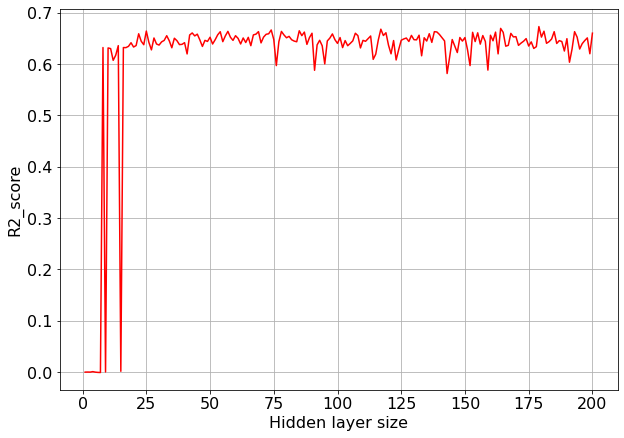

In [ ]:
plt.plot(results_hls['n_hidden_neurons'], results_hls['R2_score'], c = 'r', )

plt.rcParams.update({'font.size': 16})

plt.grid(b=1)

plt.ylabel('R2_score')  

plt.xlabel('Hidden layer size');

# MLP (keras) Titanic_df

**Data reading:**

In [ ]:
seed = 1

data_path = 'NN_datasets/1lb/'

titanic_df = pd.read_csv(data_path + 'train.csv')

In [ ]:
titanic_df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

**Filling missing values:**

In [ ]:
titanic_df['Age'].fillna(titanic_df['Age'].mean(), inplace=True)

titanic_df['Cabin'].fillna('Z', inplace=True)

titanic_df['Embarked'].fillna('S', inplace=True)

**Extracting indicator values:**

In [ ]:
titanic_df['Cabin_letter'] = titanic_df['Cabin'].str[0]  

titanic_df = pd.get_dummies(titanic_df, columns=['Pclass', 'Embarked', 'Cabin_letter', 'Sex']) 

**Drop unnecessary data:**

In [ ]:
titanic_df = titanic_df.drop(['PassengerId', 'Ticket', 'Name',  'Cabin'], axis=1)

**Separation:**

In [ ]:
train_df = titanic_df.sample(frac=.8, random_state = seed)

test_df = titanic_df[~titanic_df.index.isin(train_df.index)]

train_x = train_df.drop('Survived', axis=1);      test_x = test_df.drop('Survived', axis=1)

train_y = train_df['Survived'];                   test_y = test_df['Survived']

**Input data form:**

In [ ]:
train_x.head(5)

,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Cabin_letter_A,Cabin_letter_B,Cabin_letter_C,Cabin_letter_D,Cabin_letter_E,Cabin_letter_F,Cabin_letter_G,Cabin_letter_T,Cabin_letter_Z,Sex_female,Sex_male
862,48.000000,0,0,25.9292,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0
223,29.699118,0,0,7.8958,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,1
84,17.000000,0,0,10.5000,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0
680,29.699118,0,0,8.1375,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,1,0
535,7.000000,0,2,26.2500,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0


**NN topology example:**

In [ ]:
%%time

model = keras.Sequential([keras.Input(shape=test_x.shape[1]), 
                          layers.Dense(15, activation=activations.sigmoid), 
                          layers.Dense(1, activation=activations.sigmoid)])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(train_x, train_y, epochs=500, validation_split=0.1, batch_size=16, verbose=0)

Wall time: 18.3 s


In [ ]:
preds = model.predict(test_x)

scores = model.evaluate(test_x, test_y, batch_size=16)

12/12 [==============================] - 0s 667us/step - loss: 0.3833 - accuracy: 0.8483


**Creating dataframe with actual(!) information about whether passenger survived or not (test_y) and possibilities of surviving (MLP predictions (=preds)):**

In [ ]:
tracking_df = pd.DataFrame(zip(test_y, np.around(preds,4)), columns=(['Actual', 'Possibility']))

In [ ]:
tracking_df[25:40]

,Actual,Possibility
25,0,[0.0816]
26,0,[0.3195]
27,1,[0.9895]
28,0,[0.2202]
29,0,[0.0474]
30,0,[0.0911]
31,1,[0.9762]
32,1,[0.9574]
33,1,[0.9876]
34,0,[0.0813]


**Grid search cycle:**

In [ ]:
selection_eppoch = 10

In [ ]:
%%time

results_grid_df = pd.DataFrame()

batch_size = 16

for quan_grid in range(1,selection_eppoch+1):

    model_grid = keras.Sequential([keras.Input(shape=train_x.shape[1]), 
                          layers.Dense(quan_grid, activation=activations.relu), 
                          layers.Dense(1, activation=activations.sigmoid)])

    model_grid.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    model_grid.fit(train_x, train_y, epochs=300, validation_split=0.1, batch_size=batch_size, verbose=0)
    
    preds_grid = model_grid.predict(test_x)
    
    scores_grid  = model_grid.evaluate(test_x, test_y, batch_size=batch_size, verbose=0)
       
    result_grid = {'n_hidden_neurons': [quan_grid], 'Accuracy': [scores_grid[1]], 'Log_Loss': [scores_grid[0]]}
    
    results_grid_df = results_grid_df.append(pd.DataFrame.from_dict(result_grid))

Wall time: 2min 11s


In [ ]:
results_grid_df.sort_values(by='Accuracy').tail(5)

,n_hidden_neurons,Accuracy,Log_Loss
0,5,0.837079,0.402232
0,3,0.842697,0.408148
0,8,0.842697,0.391902
0,10,0.842697,0.382452
0,9,0.848315,0.404462


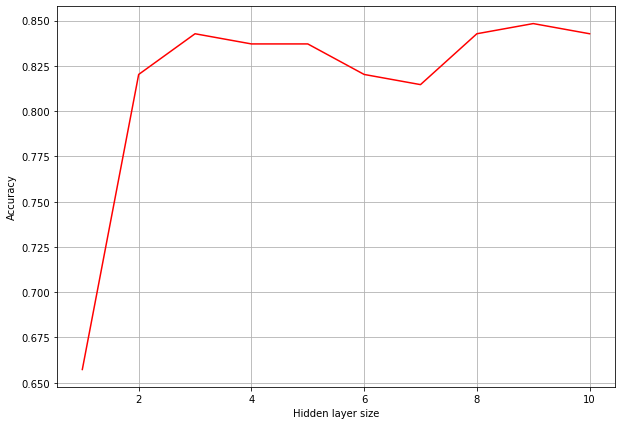

In [ ]:
plt.plot(results_grid_df['n_hidden_neurons'], results_grid_df['Accuracy'], c = 'r', )

plt.rcParams.update({'font.size': 16})

plt.grid(b=1)

plt.ylabel('Accuracy')  

plt.xlabel('Hidden layer size');

**Random search cycle:**

In [ ]:
selection_eppoch = 10

In [ ]:
np.random.seed(seed)
   
quan_rand = random.sample(range(1, 30), selection_eppoch)

quan_rand.sort()

In [ ]:
quan_rand

[1, 3, 5, 12, 14, 22, 23, 24, 26, 27]

In [ ]:
%%time

results_rand_df = pd.DataFrame()

batch_size = 16

for i in range(selection_eppoch):

    model_rand = keras.Sequential([keras.Input(shape=train_x.shape[1]), 
                          layers.Dense(quan_rand[i], activation=activations.relu), 
                          layers.Dense(1, activation=activations.sigmoid)])

    model_rand.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    model_rand.fit(train_x, train_y, epochs=300, validation_split=0.1, batch_size=batch_size, verbose=0)
    
    preds_rand = model_rand.predict(test_x)
    
    scores_rand  = model_rand.evaluate(test_x, test_y, batch_size=batch_size, verbose=0)
       
    result_rand = {'n_hidden_neurons': [quan_rand[i]], 'Accuracy': [scores_rand[1]], 'Log_Loss': [scores_rand[0]]}
    
    results_rand_df = results_rand_df.append(pd.DataFrame.from_dict(result_rand))

Wall time: 2min 9s


In [ ]:
results_rand_df.sort_values(by='Accuracy').tail(5)

,n_hidden_neurons,Accuracy,Log_Loss
0,23,0.848315,0.402821
0,14,0.853933,0.394131
0,22,0.853933,0.410444
0,27,0.853933,0.406848
0,24,0.865169,0.408781


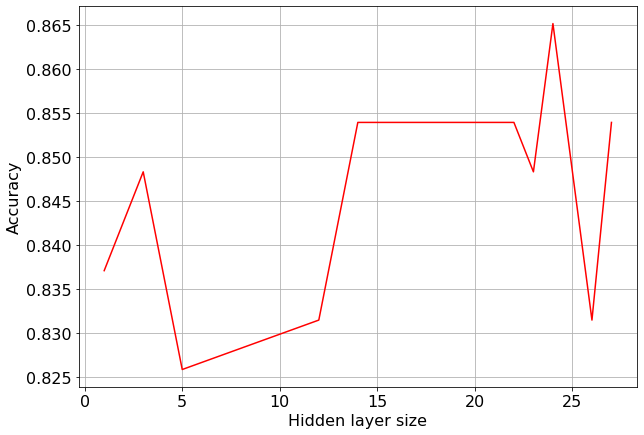

In [ ]:
plt.plot(results_rand_df['n_hidden_neurons'], results_rand_df['Accuracy'], c = 'r', )

plt.rcParams.update({'font.size': 16})

plt.grid(b=1)

plt.ylabel('Accuracy')  

plt.xlabel('Hidden layer size');